### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score,precision_recall_curve)
from sklearn.metrics import average_precision_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
sns.set(rc={'figure.figsize':(12,10)})

### Read Dataset

In [2]:
df = pd.read_csv('training.tsv', sep='\t',names=['user_id','activity_date','activity_type'])

In [3]:
df.head()

,user_id,activity_date,activity_type
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4918677 entries, 0 to 4918676
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        object
 1   activity_date  object
 2   activity_type  object
dtypes: object(3)
memory usage: 112.6+ MB


In [5]:
df.activity_date = pd.to_datetime(df.activity_date)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='activity_date', ylabel='activity_type'>

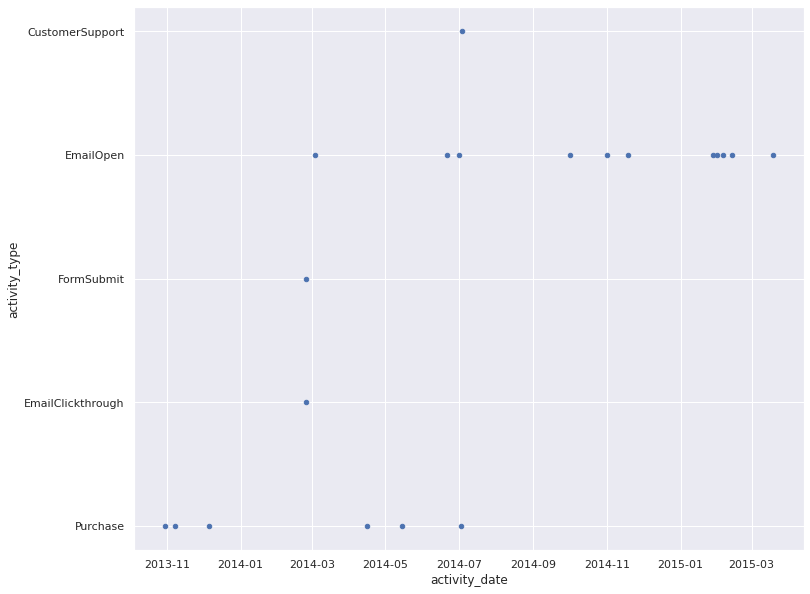

In [6]:
df[df.user_id=='0000ecf58c94668'].plot.scatter(x='activity_date',y='activity_type')

In [7]:
df[df.user_id=='0000ecf58c94668']

,user_id,activity_date,activity_type
30,0000ecf58c94668,2013-10-30,Purchase
31,0000ecf58c94668,2013-11-08,Purchase
32,0000ecf58c94668,2013-12-06,Purchase
33,0000ecf58c94668,2014-02-24,EmailClickthrough
34,0000ecf58c94668,2014-02-24,FormSubmit
35,0000ecf58c94668,2014-03-04,EmailOpen
36,0000ecf58c94668,2014-04-16,Purchase
37,0000ecf58c94668,2014-05-15,Purchase
38,0000ecf58c94668,2014-06-21,EmailOpen
39,0000ecf58c94668,2014-07-01,EmailOpen


In [8]:
oldest_df=df.groupby('user_id')['activity_date'].min()

In [9]:
df = df.merge(oldest_df,how='left',on='user_id',suffixes=['','_oldest'])
df.activity_date-df.activity_date_oldest

0          0 days
1          0 days
2          4 days
3          6 days
4          7 days
            ...  
4918672    0 days
4918673    1 days
4918674    8 days
4918675   48 days
4918676   58 days
Length: 4918677, dtype: timedelta64[ns]

#### As CustomerSupport happens after Purchase, removing rows with activity type CustomerSupport

In [10]:
df=df[df.activity_type!="CustomerSupport"]

#### Removing If Purchase happens before any other activities

In [11]:
other_oldest_df = df[df.activity_type!="Purchase"].groupby('user_id')['activity_date'].min()
other_act_df = df.merge(other_oldest_df, how='inner',on='user_id',suffixes=['','_oth'])

In [12]:
no_prior_purchase_df =other_act_df[other_act_df.activity_date>=other_act_df.activity_date_oth]

In [13]:
user_list = no_prior_purchase_df[no_prior_purchase_df.activity_type=='Purchase'].groupby('user_id').count().index[:10]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

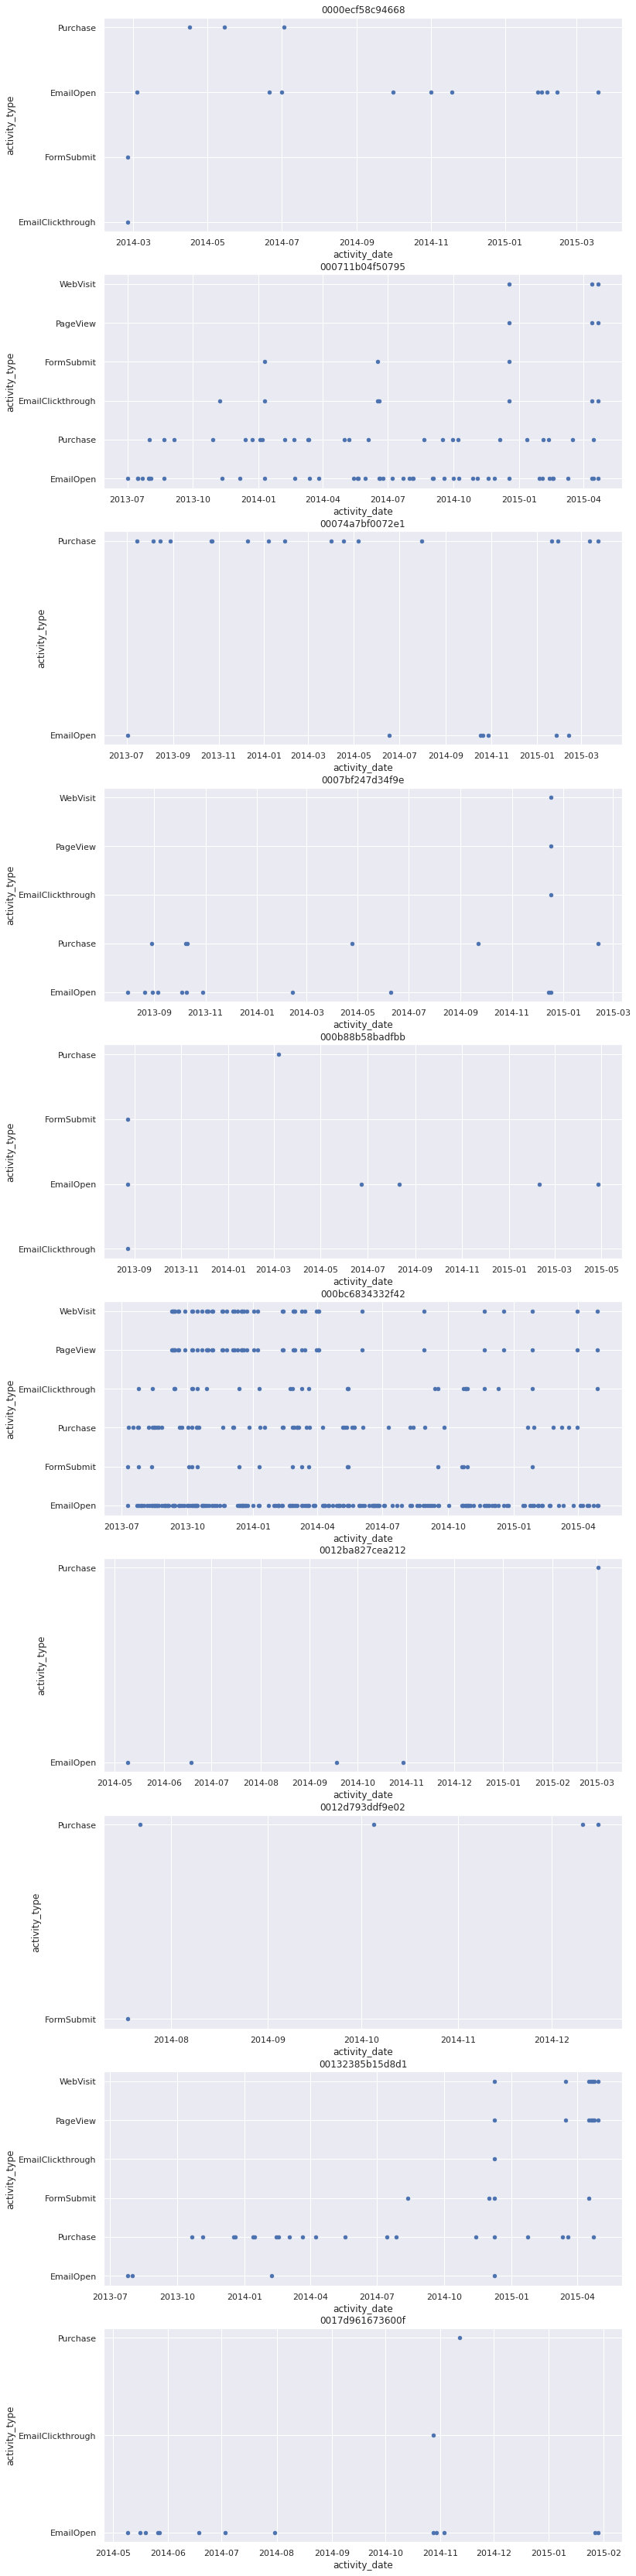

In [14]:
fig,axes = plt.subplots(10,1,figsize=(12,60))
for i,user in enumerate(user_list):
    axes[i].title.set_text(user)
    no_prior_purchase_df[no_prior_purchase_df.user_id==user].plot.scatter(x='activity_date',y='activity_type',ax=axes[i])

In [15]:
user_act_df = no_prior_purchase_df.pivot_table(index='user_id',values='activity_date',columns='activity_type',aggfunc='count',fill_value=0).reset_index()

#### Creating P_flag for users who have purchased

In [16]:
user_act_df['p_flag']=user_act_df.Purchase.apply(lambda x:x if x==0 else 1)

In [17]:
user_act_df.p_flag.sum()/user_act_df.shape[0]

0.12690180179208765

In [18]:
user_act_df.describe()

activity_type,EmailClickthrough,EmailOpen,FormSubmit,PageView,Purchase,WebVisit,p_flag
count,278223.000000,278223.000000,278223.000000,278223.000000,278223.000000,278223.000000,278223.000000
mean,1.026400,11.471848,0.632827,1.373945,0.799150,1.380278,0.126902
std,4.921969,25.107673,3.097142,10.891227,5.086057,10.883910,0.332864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,463.000000,630.000000,430.000000,596.000000,352.000000,596.000000,1.000000


In [19]:
user_act_df.quantile([0,0.25,0.5,0.75,0.9,0.99,0.995,1])

activity_type,EmailClickthrough,EmailOpen,FormSubmit,PageView,Purchase,WebVisit,p_flag
0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.250,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0.500,0.0,4.0,0.0,0.0,0.0,0.0,0.0
0.750,1.0,11.0,1.0,0.0,0.0,0.0,0.0
0.900,2.0,28.0,1.0,1.0,1.0,1.0,1.0
0.990,16.0,123.0,8.0,33.0,16.0,33.0,1.0
0.995,25.0,167.0,14.0,64.0,26.0,64.0,1.0
1.000,463.0,630.0,430.0,596.0,352.0,596.0,1.0


<AxesSubplot:>

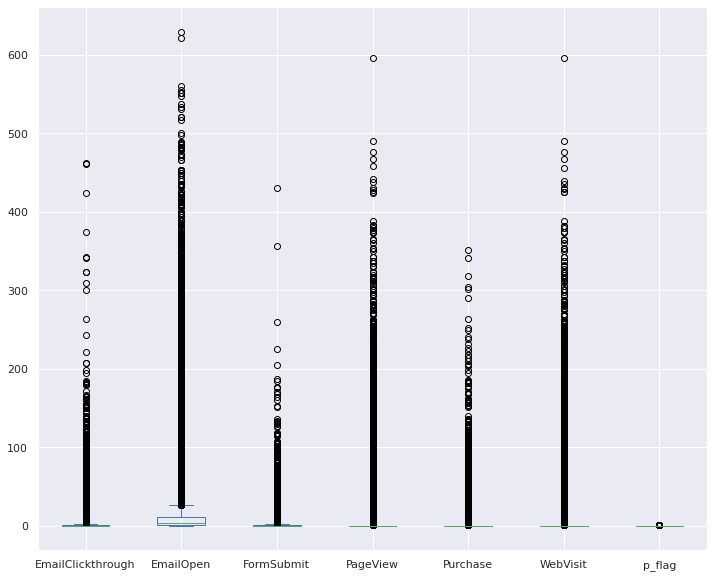

In [20]:
user_act_df.plot.box()

In [21]:
user_act_df.columns

Index(['user_id', 'EmailClickthrough', 'EmailOpen', 'FormSubmit', 'PageView',
       'Purchase', 'WebVisit', 'p_flag'],
      dtype='object', name='activity_type')

In [22]:
user_act_no_ol_df = user_act_df[(user_act_df['EmailClickthrough']<=25) &
                                 (user_act_df['EmailOpen']<=167) &
                                 (user_act_df['FormSubmit']<=14) &
                                 (user_act_df['PageView']<=64) &
                                 (user_act_df['WebVisit']<=64)]

In [23]:
user_act_no_ol_df.p_flag.sum()/user_act_df.shape[0]

0.11900525837188154

<AxesSubplot:xlabel='activity_type', ylabel='activity_type'>

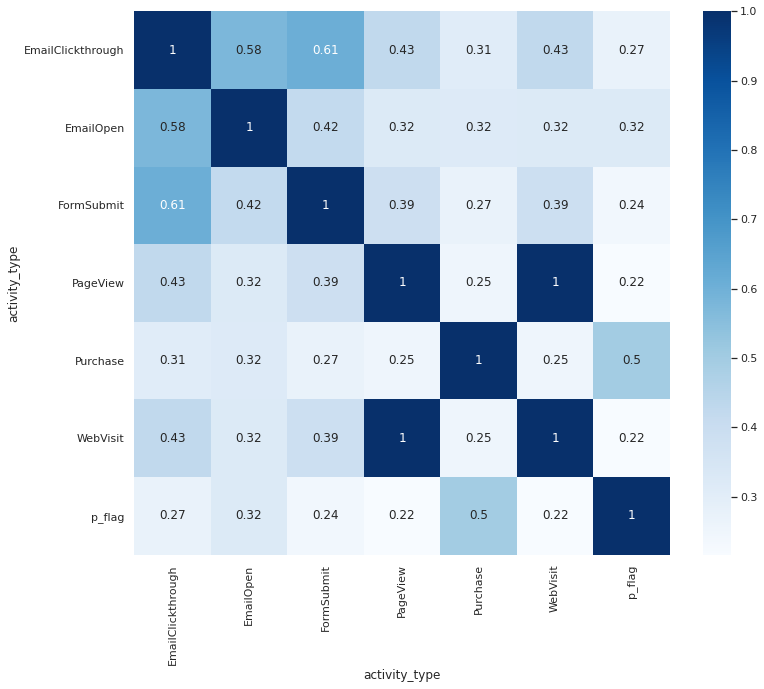

In [24]:
sns.heatmap(user_act_no_ol_df.corr(), cmap="Blues", annot=True)

#### WebVisit & PageView have very high correlation

In [25]:
user_act_no_ol_df.PageView.corr(user_act_no_ol_df.WebVisit)

0.9993802959049732

In [26]:
X=user_act_no_ol_df.drop(['Purchase','p_flag','user_id'],axis=1)
y=user_act_no_ol_df['p_flag']

In [27]:
X.columns

Index(['EmailClickthrough', 'EmailOpen', 'FormSubmit', 'PageView', 'WebVisit'], dtype='object', name='activity_type')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [29]:
X_train

activity_type,EmailClickthrough,EmailOpen,FormSubmit,PageView,WebVisit
262137,12,13,0,7,7
160623,0,0,1,0,0
101396,0,6,0,0,0
32141,0,0,2,2,2
242983,1,1,1,0,0
...,...,...,...,...,...
215314,5,24,0,0,0
66369,0,5,0,0,0
256630,0,21,0,0,0
213137,0,28,0,0,0


In [30]:
logm1 = sm.Logit(y_train,(sm.add_constant(X_train)))
logm1=logm1.fit()
logm1.summary()

Optimization terminated successfully.
         Current function value: 0.324223
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 p_flag   No. Observations:               192644
Model:                          Logit   Df Residuals:                   192638
Method:                           MLE   Df Model:                            5
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.1161
Time:                        12:29:18   Log-Likelihood:                -62460.
converged:                       True   LL-Null:                       -70661.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.5673      0.009   -270.469      0.000      -2.586      -2.549
EmailClickthrough     0.0530      0.004     12.185      0.000       0.045       0.062
EmailOpen             0.0285      0.000     66.755      0.000       0.028       0.029
FormSubmit            0.1575      0.007     21.716      0.000       0.143       0.172
PageView              0.1810      0.061      2.947      0.003       0.061       0.301
WebVisit             -0.1307      0.061     -2.126      0.033      -0.251      -0.010
=====================================================================================
"""

In [31]:
def get_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [32]:
get_vif(X_train)

,Features,VIF
4,WebVisit,780.53
3,PageView,778.53
0,EmailClickthrough,2.35
2,FormSubmit,1.93
1,EmailOpen,1.77


#### The VIF factor of WebVisit is very high means it can be explained very well by other features. Thatswhy it is removed

In [33]:
X_train.drop(['WebVisit'],axis=1, inplace=True)

In [34]:
logm2 = sm.Logit(y_train,(sm.add_constant(X_train)))
logm2=logm2.fit()
logm2.summary()

Optimization terminated successfully.
         Current function value: 0.324238
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 p_flag   No. Observations:               192644
Model:                          Logit   Df Residuals:                   192639
Method:                           MLE   Df Model:                            4
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.1160
Time:                        12:29:19   Log-Likelihood:                -62462.
converged:                       True   LL-Null:                       -70661.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.5677      0.009   -270.535      0.000      -2.586      -2.549
EmailClickthrough     0.0537      0.004     12.356      0.000       0.045       0.062
EmailOpen             0.0285      0.000     66.802      0.000       0.028       0.029
FormSubmit            0.1550      0.007     21.646      0.000       0.141       0.169
PageView              0.0505      0.002     26.641      0.000       0.047       0.054
=====================================================================================
"""

## Activity Types that are most useful
1. FormSubmit
2. EmailClickthrough
3. PageView

In [35]:
y_hat_train = logm2.predict(sm.add_constant(X_train))

In [36]:
prediction = list(map(round, y_hat_train))


In [37]:
cm = confusion_matrix(y_train, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Train accuracy = ', accuracy_score(y_train, prediction))

Confusion Matrix : 
 [[167706   1833]
 [ 20034   3071]]
Train accuracy =  0.886490106102448


#### Testing the performance on test dataset

In [38]:
y_hat_test = logm2.predict(sm.add_constant(X_test[X_train.columns]))

<AxesSubplot:xlabel='EmailOpen', ylabel='EmailClickthrough'>

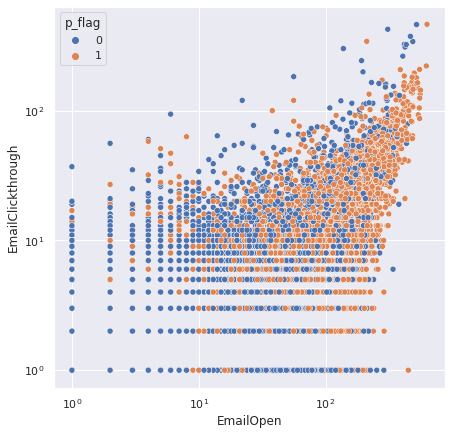

In [39]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=user_act_df, x='EmailOpen',y='EmailClickthrough',hue='p_flag',ax=ax)

In [40]:
yhat = logm2.predict(sm.add_constant(X_test[X_train.columns]))


In [41]:
prediction = list(map(round, yhat))


In [42]:
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[71764   793]
 [ 8727  1278]]
Test accuracy =  0.8846927157772341


### Prediction

In [43]:
tdf = pd.read_csv('test.tsv', sep='\t',names=['user_id','activity_date','activity_type'])

In [44]:
tdf_t = tdf.pivot_table(index='user_id',values='activity_date',columns='activity_type',aggfunc='count',fill_value=0).reset_index()

In [45]:
tdf_t

activity_type,user_id,EmailClickthrough,EmailOpen,FormSubmit,PageView,WebVisit
0,0000ecf58c94668,0,5,0,0,0
1,000132f21724ee2,1,1,0,0,0
2,0001b315b991cf0,0,3,0,0,0
3,000269150971d08,0,4,0,0,0
4,000297ba4fa5026,0,3,0,0,0
...,...,...,...,...,...,...
132805,fffc7f2ad169c6b,0,1,0,0,0
132806,fffd77a0266d37c,0,3,1,1,1
132807,fffed482b52afd8,0,1,0,0,0
132808,ffffa4cc0190881,0,1,0,0,0


In [46]:
test_X = tdf_t[X_train.columns]

In [47]:
tdf.user_id.unique().shape

(132810,)

In [48]:
test_y_hat = logm2.predict(sm.add_constant(test_X))

In [49]:
purchase_1000 = tdf_t.iloc[test_y_hat.sort_values(ascending=False)[:1000].index,0]

In [50]:
purchase_1000.to_csv('purchase_1000.csv', index=False)